In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import missingno as msno


df = pd.read_csv('../data/data.csv')

## Descripción de los datos

In [34]:
print(df.head())
print('\n\n')
print(df.tail())

   ID_pedido Fecha_pedido Fecha_picking Fecha_factura Fecha_entrega
0          1   2023-07-14    2023-07-18    2023-07-20    2023-07-21
1          2   2021-03-03    2021-03-04    2021-03-05    2021-03-08
2          3   2020-03-31    2020-04-03    2020-04-03    2020-04-10
3          4   2020-11-06    2020-11-09    2020-11-09    2020-11-17
4          5   2022-07-27    2022-07-29    2022-07-30    2022-08-02



     ID_pedido Fecha_pedido Fecha_picking Fecha_factura Fecha_entrega
995        996   2023-05-23    2023-05-27    2023-05-28    2023-06-04
996        997   2023-11-11    2023-11-13    2023-11-14    2023-11-18
997        998   2022-08-01    2022-08-04    2022-08-06    2022-08-13
998        999   2023-04-12    2023-04-16    2023-04-16    2023-04-23
999       1000   2020-10-01    2020-10-05    2020-10-06    2020-10-06


Tenemos un dataframe con 5 columnas, estas representan:

1. **ID_pedido:** Identificador único del pedido.
2. **Fecha_pedido:** Fecha en la que el cliente generó su pedido
3. **Fecha_picking:** Fecha en la que la mercancía se comienza a sutrir dentro del almacén
4. **Fecha_factura:** Fecha en la que el material está surtido y se genera la factura
5. **Fecha_entrega:** Fecha en la que el cliente recibe su mercancía

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_pedido      1000 non-null   int64 
 1   Fecha_pedido   994 non-null    object
 2   Fecha_picking  989 non-null    object
 3   Fecha_factura  992 non-null    object
 4   Fecha_entrega  995 non-null    object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


Se puede observar que tenermos algunos valores vacíos en las columnas de fecha, probablemente la persona que llena la información en el sistema olvidó llenar esas fechas

También se puede observar que las columnas de fecha son de tipo objeto en lugar de tener tipo fecha

In [36]:
# Se cuentan los valores unicos de cada columa para ver un poco la variabilidad de los datos

unique_counts = df.nunique()
print(unique_counts)

ID_pedido        1000
Fecha_pedido      731
Fecha_picking     729
Fecha_factura     714
Fecha_entrega     698
dtype: int64


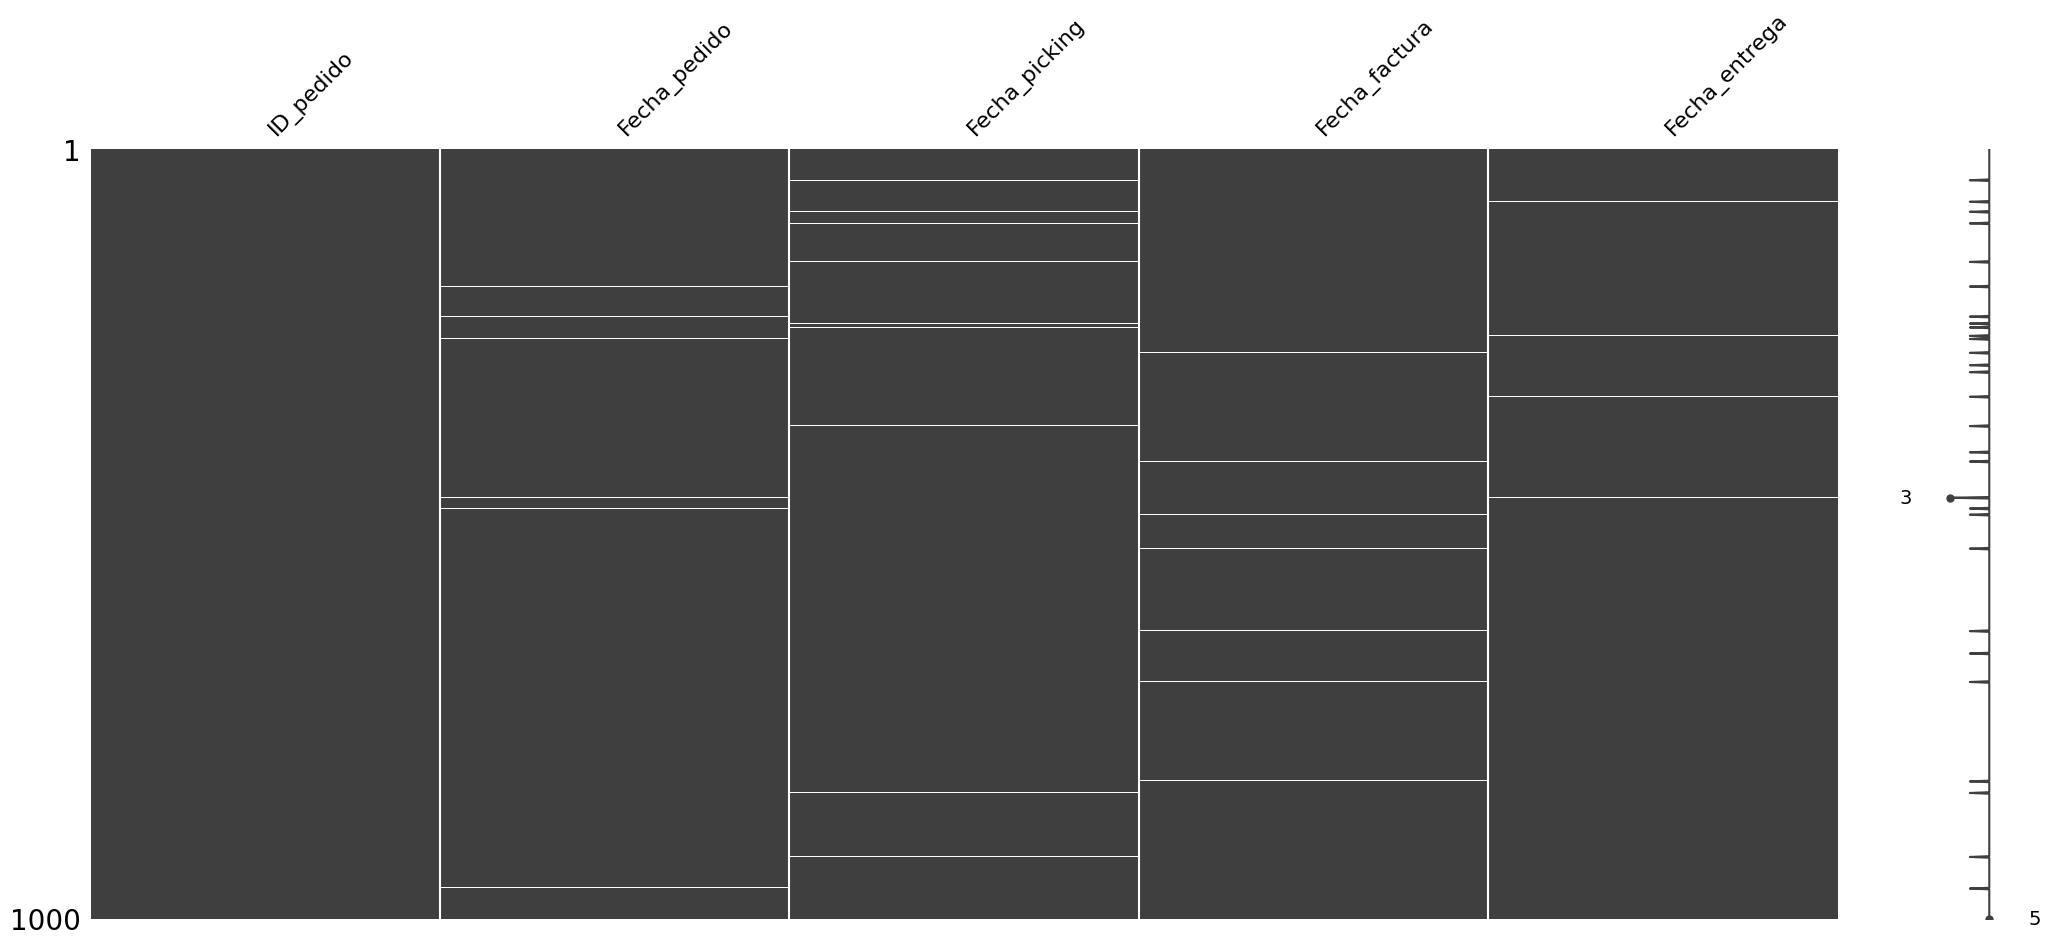

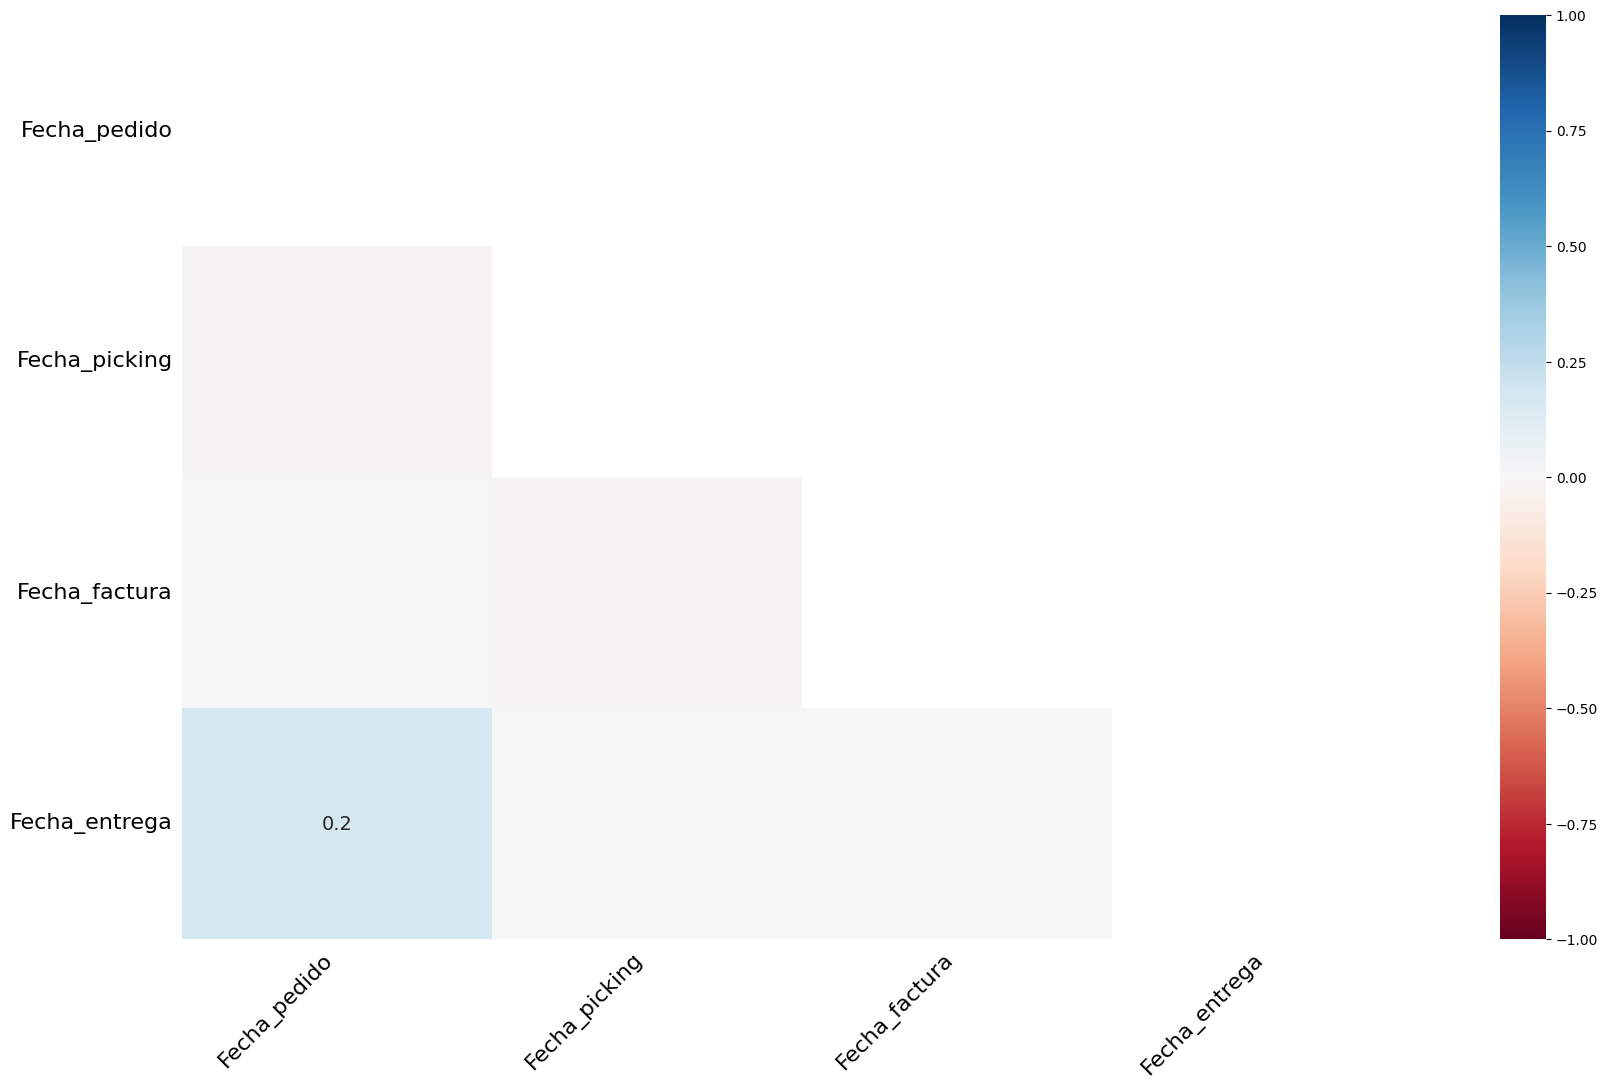

In [37]:
# Mapa de calor de valores faltantes
msno.matrix(df)
plt.show()

# Mapa de calor de correlación de valores faltantes (si es relevante)
msno.heatmap(df)
plt.show()

Con estos visuales se puede observar gráficamente que faltan algunos datos, pero no son muchos

# Limpieza de datos

Primero se convierten las columnas de fecha al tipo correspondiente 

In [38]:
# Lista de columnas de fecha
columnas_de_fecha = ["Fecha_pedido", "Fecha_picking", "Fecha_factura", "Fecha_entrega"]

# Convertir las columnas de fecha al tipo datetime
for columna in columnas_de_fecha:
    df[columna] = pd.to_datetime(df[columna], format="%Y-%m-%d")


Se llenan los datos vacíos con fechas promedio

In [39]:
# Generar valores dummy para llenar los registros vacíos

# Calcular los días que transcurren entre cada parte del proceso y guardarlas en nuevas columnas
def calcular_dias_transcurridos():
    df['dias_pedido_picking'] = (df['Fecha_picking'] - df['Fecha_pedido']).dt.days
    df['dias_picking_factura'] = (df['Fecha_factura'] - df['Fecha_picking']).dt.days
    df['dias_factura_entrega'] = (df['Fecha_entrega'] - df['Fecha_factura']).dt.days

calcular_dias_transcurridos()

# Calcular las medias
media_dias_pedido_picking = df['dias_pedido_picking'].mean()
media_dias_picking_factura = df['dias_picking_factura'].mean()
media_dias_factura_entrega = df['dias_factura_entrega'].mean()

# Llenar los valores vacíos
df['Fecha_pedido'].fillna(df['Fecha_picking'] - pd.to_timedelta(round(media_dias_pedido_picking,0), unit='D'), inplace=True)
df['Fecha_picking'].fillna(df['Fecha_factura'] - pd.to_timedelta(round(media_dias_picking_factura,0), unit='D'), inplace=True)
df['Fecha_factura'].fillna(df['Fecha_entrega'] - pd.to_timedelta(round(media_dias_factura_entrega,0), unit='D'), inplace=True)
df['Fecha_entrega'].fillna(df['Fecha_factura'] + pd.to_timedelta(round(media_dias_factura_entrega,0), unit='D'), inplace=True)

calcular_dias_transcurridos()

print('Validación \n')

print(df.info())

Validación 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID_pedido             1000 non-null   int64         
 1   Fecha_pedido          1000 non-null   datetime64[ns]
 2   Fecha_picking         1000 non-null   datetime64[ns]
 3   Fecha_factura         1000 non-null   datetime64[ns]
 4   Fecha_entrega         1000 non-null   datetime64[ns]
 5   dias_pedido_picking   1000 non-null   int32         
 6   dias_picking_factura  1000 non-null   int32         
 7   dias_factura_entrega  1000 non-null   int32         
dtypes: datetime64[ns](4), int32(3), int64(1)
memory usage: 50.9 KB
None


Validar si tenemos outliers mediante el rango intercuantil

In [47]:
def handle_outliers(df, columns, remove=False):
    df_copy = df.copy()  # Hacer una copia del DataFrame para evitar cambios permanentes
    all_outliers = []

    for column_name in columns:
        # Calcular los cuantiles y el rango intercuartil (IQR)
        Q1 = df_copy[column_name].quantile(0.25)
        Q3 = df_copy[column_name].quantile(0.75)
        IQR = Q3 - Q1

        # Calcular los límites para identificar outliers
        lower_bound = 0  
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df_copy[(df_copy[column_name] < lower_bound) | (df_copy[column_name] > upper_bound)]

        # Almacenar los resultados en la lista
        all_outliers.append(outliers)

        # Eliminar las filas con outliers
        if remove:
            df_copy = df_copy.drop(outliers.index).reset_index(drop=True)
        
    # Combinar todos los resultados en un único DataFrame de outliers
    combined_outliers = pd.concat(all_outliers, axis=0)

    if remove:
        return df_copy
    else:
        return combined_outliers

In [48]:
# Lista de columnas en las que se identificarán outliers
columns_to_check = ["dias_pedido_picking", "dias_picking_factura", "dias_factura_entrega"]

# Llamamos a la función para manejar outliers
outliers = handle_outliers(df, columns_to_check)

In [49]:
print(outliers)
print('\n')
print(f' Se tienen {outliers.shape[0]} registros con outliers')

     ID_pedido Fecha_pedido Fecha_picking Fecha_factura Fecha_entrega   
77          78   2020-01-12    2020-01-16    2020-01-23    2020-01-21  \
199        202   2022-09-25    2022-09-26    2022-10-10    2022-09-30   
333        339   2021-06-10    2021-06-12    2021-06-22    2021-06-19   
399        406   2020-08-11    2020-08-15    2020-08-12    2020-08-16   
416        423   2023-12-19    2023-12-19    2024-01-06    2023-12-25   
721        733   2021-04-10    2021-04-10    2021-04-21    2021-04-16   
755        769   2023-11-14    2023-11-16    2023-11-29    2023-11-16   
800        814   2022-03-24    2022-03-25    2022-04-15    2022-04-01   
825        840   2022-02-26    2022-03-01    2022-03-15    2022-03-03   
77          78   2020-01-12    2020-01-16    2020-01-23    2020-01-21   
102        103   2020-12-30    2021-01-02    2021-01-03    2021-01-28   
107        108   2023-01-23    2023-01-25    2023-01-26    2023-02-14   
151        154   2021-06-29    2021-07-02    2021-0

Se visualizan algunos valores demasiado altos y otros con números negativos, que no deberían existir, se pensó en dos formas de limpiar estos outliers:

1. Al ser pocos valores, directamente eliminarlos del dataframe
2. Cambiar la fecha que genera el outlier por una nueva lógica que sea similar a la que utilizamos para llenar los valores vacíos

Para este caso, al ser muy pocos valores,  se optó por eliminar los registros del df

In [50]:
# eliminar filas con outliers
# Lista de columnas en las que se buscarán outliers
columns = ["dias_pedido_picking", "dias_picking_factura", "dias_factura_entrega"]
# Se deja el tercer valor como True para eliminar los outliers usando la misma función que los detectó

df = handle_outliers(df, columns, True)

print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID_pedido             961 non-null    int64         
 1   Fecha_pedido          961 non-null    datetime64[ns]
 2   Fecha_picking         961 non-null    datetime64[ns]
 3   Fecha_factura         961 non-null    datetime64[ns]
 4   Fecha_entrega         961 non-null    datetime64[ns]
 5   dias_pedido_picking   961 non-null    int32         
 6   dias_picking_factura  961 non-null    int32         
 7   dias_factura_entrega  961 non-null    int32         
dtypes: datetime64[ns](4), int32(3), int64(1)
memory usage: 48.9 KB
None
     ID_pedido Fecha_pedido Fecha_picking Fecha_factura Fecha_entrega   
0            1   2023-07-14    2023-07-18    2023-07-20    2023-07-21  \
1            2   2021-03-03    2021-03-04    2021-03-05    2021-03-08   
2            3   2020-03

In [68]:
# Se vuelven a calcular las medias

media_dias_pedido_picking = df['dias_pedido_picking'].mean()
media_dias_picking_factura = df['dias_picking_factura'].mean()
media_dias_factura_entrega = df['dias_factura_entrega'].mean()

# ver que tanto representa cada una de las medias respecto a la suma de las 3
suma_dias = media_dias_pedido_picking + media_dias_picking_factura + media_dias_factura_entrega

print(f' El total de días promedio es {suma_dias} \n')
print(f' Los días promedio de pedido a picking representan un {media_dias_pedido_picking/suma_dias} % del total')
print(f' Los días promedio de picking a factura representan un {media_dias_picking_factura/suma_dias} % del total')
print(f' Los días promedio de factura a entrega representan un {media_dias_factura_entrega/suma_dias} % del total')


 El total de días promedio es 6.905306971904267 

 Los días promedio de pedido a picking representan un 0.2721518987341772 % del total
 Los días promedio de picking a factura representan un 0.14722724532851114 % del total
 Los días promedio de factura a entrega representan un 0.5806208559373116 % del total


# Visualización de datos

In [ ]:
# Crear un histograma para 'dias_pedido_picking'
histogram_dias_pedido_picking = alt.Chart(df).mark_bar().encode(
    alt.X('dias_pedido_picking:Q', bin=alt.Bin(step=1), title='Días'),
    alt.Y('count():Q', title='Frecuencia')
).properties(
    width=300,
    title='Histograma de días_pedido_picking'
)

# Crear un histograma para 'dias_picking_factura'
histogram_dias_picking_factura = alt.Chart(df).mark_bar().encode(
    alt.X('dias_picking_factura:Q', bin=alt.Bin(step=1), title='Días'),
    alt.Y('count():Q', title='Frecuencia')
).properties(
    width=300,
    title='Histograma de dias_picking_factura'
)

# Crear un histograma para 'dias_factura_entrega'
histogram_dias_factura_entrega = alt.Chart(df).mark_bar().encode(
    alt.X('dias_factura_entrega:Q', bin=alt.Bin(step=1), title='Días'),
    alt.Y('count():Q', title='Frecuencia')
).properties(
    width=300,
    title='Histograma de dias_factura_entrega'
)

# Combinar los histogramas
histograms = (histogram_dias_pedido_picking | histogram_dias_picking_factura | histogram_dias_factura_entrega)

histograms


alt.HConcatChart(...)

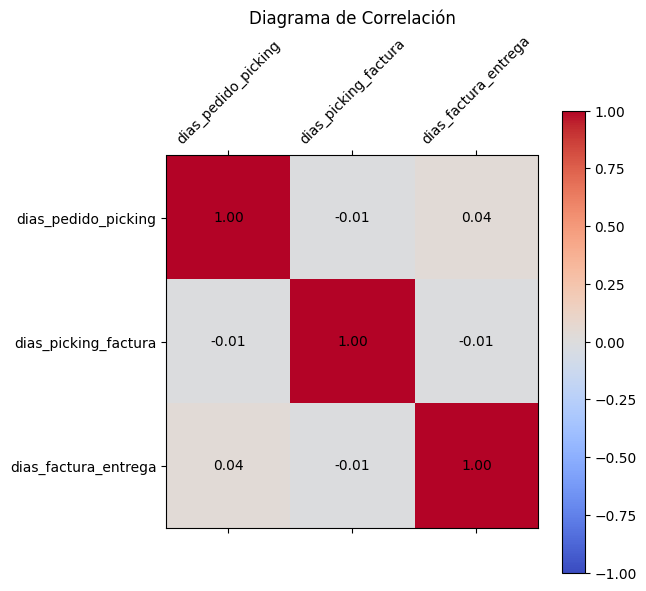

In [61]:
# Calcular la matriz de correlación
correlation_matrix = df[['dias_pedido_picking', 'dias_picking_factura', 'dias_factura_entrega']].corr()
# Create a correlation chart
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cax)

# Set labels and titles
plt.xticks(range(len(correlation_matrix.columns), ), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns), ), correlation_matrix.columns)
plt.title('Diagrama de Correlación')

# Add numbers to the center of each cell
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

# Show the chart
color_scale = alt.Scale(domain=['Red', 'Yellow', 'Green'], range=['red', 'yellow', 'green'])

scatter_plot = alt.Chart(df).mark_circle().encode(
    x='dias_pedido_picking:Q',
    y='dias_picking_factura:Q',
    color=alt.Color('dias_factura_entrega:O', scale=color_scale)
).properties(
    width=400,
    height=400,
    title='Gráfico de Dispersión'
)


In [65]:
scatter_plot = alt.Chart(df).mark_circle().encode(
    x='dias_pedido_picking:O',
    y='dias_picking_factura:O',
    color='dias_factura_entrega:O'
).properties(
    width=400,
    height=400,
    title='Gráfico de Dispersión'
)

scatter_plot

alt.Chart(...)

In [66]:
boxplot_dias_pedido_picking = alt.Chart(df).mark_boxplot().encode(
    x=alt.X('variable:N', title='Variable'),
    y=alt.Y('dias_pedido_picking:Q', title='Días')
).transform_fold(
    ['dias_pedido_picking'],
    as_=['variable', 'value']
).properties(
    width=400,
    title='Boxplot de días_pedido_picking'
)

boxplot_dias_picking_factura = alt.Chart(df).mark_boxplot().encode(
    x=alt.X('variable:N', title='Variable'),
    y=alt.Y('dias_picking_factura:Q', title='Días')
).transform_fold(
    ['dias_picking_factura'],
    as_=['variable', 'value']
).properties(
    width=400,
    title='Boxplot de días_picking_factura'
)

boxplot_dias_factura_entrega = alt.Chart(df).mark_boxplot().encode(
    x=alt.X('variable:N', title='Variable'),
    y=alt.Y('dias_factura_entrega:Q', title='Días')
).transform_fold(
    ['dias_factura_entrega'],
    as_=['variable', 'value']
).properties(
    width=400,
    title='Boxplot de días_factura_entrega'
)

# Combina los boxplots en un solo gráfico
boxplots = (boxplot_dias_pedido_picking | boxplot_dias_picking_factura | boxplot_dias_factura_entrega)

boxplots

alt.HConcatChart(...)

In [69]:
medias = [media_dias_pedido_picking, media_dias_picking_factura, media_dias_factura_entrega]

# Calcula el porcentaje de cada media con respecto a la suma total
suma_dias = sum(medias)
medias_pct_total = [media / suma_dias for media in medias]

# Crea un DataFrame con los datos
data = {
    'Categoría': ['Pedido a Picking', 'Picking a Factura', 'Factura a Entrega'],
    'Media_pct_total': medias_pct_total
}

df = pd.DataFrame(data)

# Crea un gráfico de barras apiladas
bar_chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Categoría:N', title='Categoría'),
    y=alt.Y('Media_pct_total:Q', axis=alt.Axis(format='%'), title='% del Total'),
    color=alt.Color('Categoría:N', scale=alt.Scale(scheme='set1'))
).properties(
    width=400,
    title='Medias respecto a la suma total'
)

bar_chart

alt.Chart(...)

In [81]:
# Supongamos que tienes las medias en una lista o variable
medias = [media_dias_pedido_picking, media_dias_picking_factura, media_dias_factura_entrega]

# Calcula el porcentaje de cada media con respecto a la suma total
suma_dias = sum(medias)
medias_pct_total = [media / suma_dias * 100 for media in medias]  # Convertido a porcentaje

# Crea un DataFrame con los datos
data = {
    'Categoría': ['Pedido a Picking', 'Picking a Factura', 'Factura a Entrega'],
    'Media_pct_total': medias_pct_total
}

df = pd.DataFrame(data)

# Crea un gráfico radial (Radial Chart) con formato de eje personalizado
source = df

base = alt.Chart(source).encode(
    alt.Theta("Media_pct_total:Q", stack=True),
    alt.Radius("Media_pct_total:Q").scale(type="sqrt", zero=True, rangeMin=20),
    color="Categoría:N",
)

arc = base.mark_arc(innerRadius=20, stroke="#fff")

text = base.mark_text(radiusOffset=10).encode(text=alt.Text("Media_pct_total:Q", format=".1f"))  # Formato con 1 decimal

arc + text


alt.LayerChart(...)